In [1]:
from torch.utils.data import Dataset
from datasets import load_dataset

from pathlib import Path
import os
import torch.nn as nn

import lightning.pytorch as pl
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import cv2
import shutil
import numpy as np

from patchify import patchify

import nibabel as nib
import matplotlib.pyplot as plt

from nibabel.processing import resample_to_output

# import sys
# sys.path.append('/home/pawel/Documents/RISA/3D_segmentation/segmentation_models.pytorch.3d')

# print(sys.path)

import segmentation_models_pytorch as smp
import torch
import torchmetrics

from x_unet import XUnet
from monai.losses import DiceLoss
import monai
from torch.nn.modules.loss import _Loss
from monai.networks.nets import UNet
from monai.networks.layers import Norm

/home/pawel/Documents/RISA/3D_segmentation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [10]:
class CTDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image_file = np.load(str(image_filepath))

        path_elements = list(Path(image_filepath).parts)
        index = path_elements.index('scans')
        path_elements[index] = 'airways'

        mask_filepath = os.path.join(*path_elements)
        mask_file = np.load(str(mask_filepath))

        # print('scan path:', image_filepath)
        # print('mask path:', mask_filepath)

        if self.transform is not None:
            transformed_images = []
            transformed_masks = []
            for i in range(0, image_file.shape[-1]):
                
                image_slice = image_file[..., i]
                mask_slice = mask_file[..., i]

                # print("Shapes:", image_slice.shape, mask_slice.shape)

                transformed = self.transform(image=image_slice, mask=mask_slice)

                # print("Shapes:", transformed["image"].shape, transformed["mask"].shape)

                transformed_images.append(transformed["image"])
                transformed_masks.append(transformed["mask"])

            image_file = torch.stack(transformed_images, dim=0)
            mask_file = torch.stack(transformed_masks, dim=0).type(torch.float16)
            # mask_file = mask_file.unsqueeze(0)
            # mask_file = mask_file.unsqueeze(1)
            # mask_file = monai.networks.utils.one_hot(mask_file, num_classes=2)
            # mask_file = mask_file.permute(0, 3, 1, 2).float()
            mask_file = mask_file.unsqueeze(0)

            image_file = image_file.permute(1, 0, 2, 3)

            # print('shape: ', image_file.shape, mask_file.shape)
            # print("len of tuple: ", i, image_file.shape, mask_file.shape)
            # print("Type: ", type(image_file), type(mask_file))
            # print("image: ", image_file[0, 0, ...].min(), image_file[0, 0, ...].max())
            # print("mask: ", image_file[0, 0, ...].min(), image_file[0, 0, ...].max())


            # print(image_file)
            # print(mask_file)
        return image_file, mask_file
        # return torch.randn(1, 1, 10, 128, 128), torch.randn(1, 3, 10, 128, 128)

# Data Module

In [11]:
class CTDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.augmentations = A.Compose([
        A.ToFloat(max_value=1024+400, always_apply=True),
        A.Resize(height=64, width=64),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.Normalize(mean=[-1024/400], std=[1/400], always_apply=True),
        ToTensorV2()
        ])
        self.transforms = A.Compose([
        A.ToFloat(max_value=1024+400, always_apply=True),
        A.Resize(height=64, width=64),
        # A.Normalize(mean=[-1024/400], std=[1/400], always_apply=True),
        ToTensorV2(),
        ])

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

        self.path_to_file = '/home/pawel/Documents/RISA/3D_segmentation/dataset'


    def prepare_data(self):
        if os.path.exists(self.path_to_file):
            print("Path exists")
            images_paths = sorted(Path(self.path_to_file).rglob('*.npy'))
            # print(images_paths)
            for image_path in images_paths:
                image = np.load(str(image_path))

                if image is None:
                    print("Unlink image: ", image_path)
                    image_path.unlink()
        else:
            print("Path does not exist")


    def setup(self, stage):
        paths = sorted(Path(os.path.join(self.path_to_file, 'scans')).glob('*.npy'))

        train_paths, val_paths = train_test_split(paths, test_size=0.3, random_state=42)
        val_paths, test_paths = train_test_split(val_paths, test_size=0.5, random_state=42)

        self.train_dataset = CTDataset(train_paths, transform=self.augmentations)
        self.val_dataset = CTDataset(val_paths, transform=self.transforms)
        self.test_dataset = CTDataset(test_paths, transform=self.transforms)

        # return self.train_dataset

    def train_dataloader(self):
        # print(DataLoader(self.train_dataset, batch_size=1).shape)
        return DataLoader(self.train_dataset, batch_size=5, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=5, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=5, num_workers=1)

In [12]:
# def loss_function(outputs, labels):

#     dice_fn = DiceLoss(to_onehot_y=True, 
#                        softmax=True, sigmoid=False,
#                        include_background=False)
#     ce_fn = torch.nn.CrossEntropyLoss(reduction='none')

#     # Dice loss
#     dice_loss = dice_fn(outputs, labels)

#     # Focal loss
#     ce = ce_fn(outputs, torch.squeeze(labels, dim=1))
#     pt = torch.exp(-ce)
#     focal_loss = (1 - pt)**2.0 * ce 
#     focal_loss = torch.mean(focal_loss)

#     # nDSC loss
#     loss_fn = nDSC_Loss()
#     loss_ndsc = loss_fn(outputs, labels)

#     loss_ce = ce.mean()

#     loss = focal_loss * 1.0 + loss_ndsc * 0.01 + loss_ce * 0.3

#     return dict(loss=loss,
#                 dice_loss=dice_loss.detach().cpu(),
#                 focal_loss=focal_loss.detach().cpu(),
#                 ndsc_loss=loss_ndsc.detach().cpu(),
#                 ce_loss=loss_ce.detach().cpu())

# Create model

In [13]:
class AirWayModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        # self.model = smp.create_model(
        #     arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        # )
        # self.model = smp.Unet_3D(
        #     encoder_name=encoder_name)
        self.model = XUnet(
            dim = 16,
            frame_kernel_size = 3,                 # set this to greater than 1
            channels = 1,
            dim_mults = (1, 2, 4, 8),
            nested_unet_depths = (5, 4, 2, 1),     # nested unet depths, from unet-squared paper
            consolidate_upsample_fmaps = True,     # whether to consolidate outputs from all upsample blocks, used in unet-squared paper
            weight_standardize = True
        )

        # self.loss_function = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        # self.loss_function = nn.CrossEntropyLoss()
        # self.loss_function = MyDiceLoss(mode=smp.losses.BINARY_MODE)
        # self.loss_function = smp.losses.DiceLoss(mode='binary')
        # self.loss_function = nn.BCEWithLogitsLoss()
        self.loss_function = DiceLoss(to_onehot_y=False, 
                            softmax=True, sigmoid=False,
                            include_background=False)

        metrics = torchmetrics.MetricCollection([tempfile.mkdtemp() if directory is None else directory
            torchmetrics.F1Score(task='BINARY'),
            torchmetrics.Precision(task='BINARY'),
            torchmetrics.Recall(task='BINARY')
        ])
        self.train_metrics = metrics.clone('train_')
        self.val_metrics = metrics.clone('val_')
        self.test_metrics = metrics.clone('test_')

        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        # labels_tensor = labels.unsqueeze(0)
        labels = torch.mean(labels, dim=1, keepdim=True)
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)
        # loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels)
        # loss = loss_function(outputs, labels)

        # self.accuracy.update(outputs, labels)
        # self.log('train_loss', loss, prog_bar=True)
        # self.log('train_acc', self.accuracy, prog_bar=True)
        # self.log('val_acc', self.validation_step, prog_bar=True)

        self.train_metrics.update(outputs, labels)
        self.log('train_loss', loss, prog_bar=True)
        self.log_dict(self.train_metrics)

        # self.append("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        # labels_tensor = labels.unsqueeze(0)
        # # print(labels)
        # # print(inputs)
        labels = torch.mean(labels, dim=1, keepdim=True)  # Oblicz średnią
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)
        # loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels)
        # loss = loss_function(outputs, labels)

        self.val_metrics.update(outputs, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log_dict(self.val_metrics)


    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = torch.mean(labels, dim=1, keepdim=True)
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)
        # loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels)
        # loss = loss_function(outputs, labels)

        # self.accuracy.update(outputs, labels)

        # self.log('test_loss', loss)
        # self.log('test_acc', self.accuracy)

        self.test_metrics.update(outputs, labels)
        self.log('test_loss', loss, prog_bar=True)
        self.log_dict(self.test_metrics)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [14]:
segment_model_3D = AirWayModel()

data_module = CTDataModule()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor = 'val_BinaryF1Score', mode='max', verbose = True)

# # logger = pl.loggers.NeptuneLogger(project="gawron.pawel1999/ZPO-Lab06", api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0MDE0NTRlMy03NDY2LTQ0OWYtYTcxMS1jMDE5OThlYjIyZjQifQ==")

trainer = pl.Trainer(accelerator='gpu',
                     callbacks = [checkpoint_callback],
                     max_epochs=10)

# Ensure the output and labels have the same size before calculating the loss
segment_model_3D = segment_model_3D.to('cuda')
# data_module = data_module.to('cuda')

trainer.fit(segment_model_3D, datamodule = data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Path exists


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | XUnet            | 4.1 M 
1 | loss_function | DiceLoss         | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.347    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

/home/pawel/Documents/RISA/3D_segmentation/.venv/lib/python3.10/site-packages/monai/losses/dice.py:146: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")
/home/pawel/Documents/RISA/3D_segmentation/.venv/lib/python3.10/site-packages/monai/losses/dice.py:161: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")


/home/pawel/Documents/RISA/3D_segmentation/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   5%|▍         | 9/194 [00:03<01:03,  2.90it/s, v_num=181, train_loss=0.993]

/home/pawel/Documents/RISA/3D_segmentation/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


: 

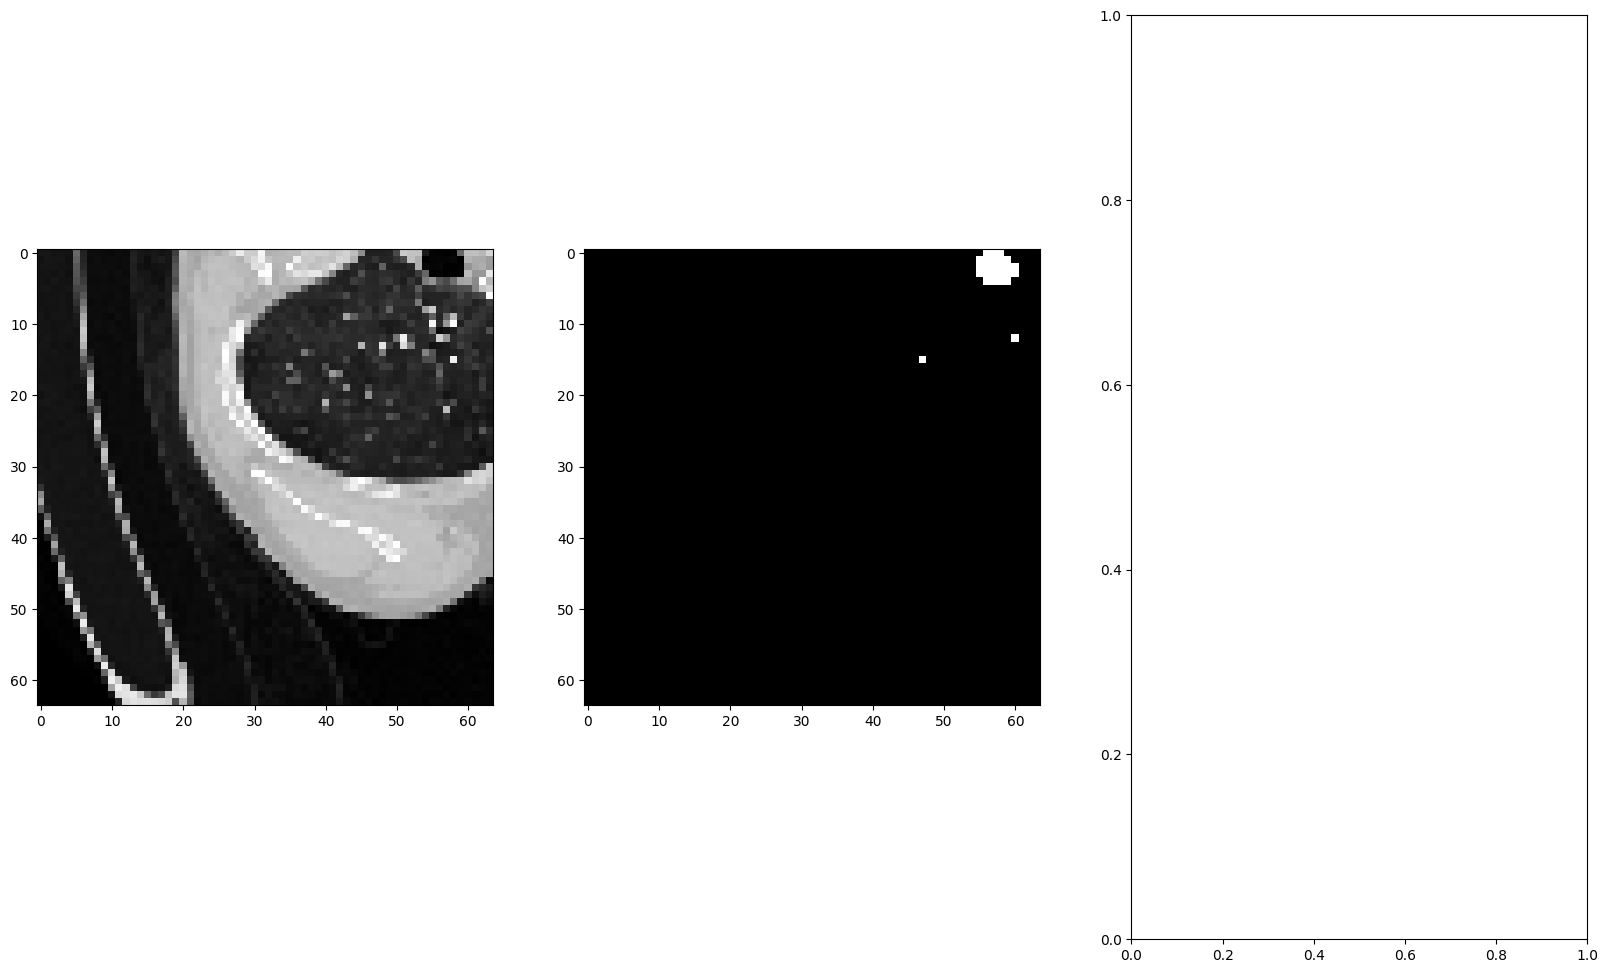

type:  <class 'torch.Tensor'>
type:  <class 'torch.Tensor'>
torch.Size([1, 50, 64, 64])
torch.Size([1, 50, 64, 64])


In [61]:
# unet = XUnet(
#     dim = 64,
#     frame_kernel_size = 3,                 # set this to greater than 1
#     channels = 1,
#     dim_mults = (1, 2, 4, 8),
#     nested_unet_depths = (5, 4, 2, 1),     # nested unet depths, from unet-squared paper
#     consolidate_upsample_fmaps = True,     # whether to consolidate outputs from all upsample blocks, used in unet-squared paper
#     weight_standardize = True
# )

dataset = CTDataModule()
scans = dataset.setup('fit')
# # print(scans)

single_scan_tuple, single_msk_tuple = scans.__getitem__(20)

slice_nr = 10

fig, ax = plt.subplots(1, 3, figsize=(20, 12))
ax[0].imshow(single_scan_tuple[0, slice_nr, :, :], cmap="gray")
ax[1].imshow(single_msk_tuple[0, slice_nr, :, :], cmap="gray")

plt.show()
# single_msk_tuple = scans.__getitem__(0)

print("type: ", type(single_scan_tuple))
print("type: ", type(single_msk_tuple))

print((single_scan_tuple.size()))
print((single_msk_tuple.size()))
# # single_scan_tuple = single_scan_tuple.unsqueeze(0)
# print(single_scan_tuple.size())

# tensors = [t for t in single_scan_tuple]  # Extract the tensor from each tuple
# stacked_tensor = torch.stack(tensors)  # Stack the tensors
# print(stacked_tensor.shape) 

# print(dataset.__getitem__(0))

# video = torch.randn(1, 3, 10, 128, 128)    # (batch, channels, frames, height, width)
# print(video.size())
# out = unet(single_scan_tuple) # (1, 3, 10, 128, 128)
# print(out)